# **EEP596: Natural Language Processing**

## Final Project - English-to-BASH

### Josh Shih, Qianyi Sha, Kevin Um

#### Download Huggingface transformer library, import required libraries, and connect all data

In [1]:
# !pip3 install -q git+https://github.com/huggingface/transformers.git
# # !pip install -q tensorflow==2.1
# !pip3 install torch==1.2.0 torchvision==0.4.0 -f
# !pip3 install datasets transformers[sentencepiece] sacrebleu
# !pip3 install sacremoses
# !pip3 install datasets

In [2]:
import transformers

print(transformers.__version__)

4.26.1


In [3]:
# !pip3 install ipywidgets

In [4]:
import yaml
with open(r'C:\Users\sha\key') as f:    
    keys = yaml.safe_load(f)

from huggingface_hub import notebook_login
import huggingface_hub
# notebook_login()
huggingface_hub.login(keys['huggingface'])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to C:\Users\sha\.cache\huggingface\token
Login successful


In [5]:
!pip install datasets

In [6]:
# Importing libraries.
import pandas as pd
from sklearn.model_selection import train_test_split

import datasets

from datasets import load_dataset, load_metric
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoTokenizer

import numpy as np

#### Data Preprocessing

In [7]:
def load_csv(input, output):
  # Input: csv_file_name
  # Output: pandas data frame
  input_df = pd.read_csv(input, sep="\r\n", header=None, names=['input'])
  output_df = pd.read_csv(output, sep="\r\n", header=None, names=['output'])
  return input_df, output_df

In [8]:
input, output = load_csv('balanced_user_input_NL2BASH.txt', 'balanced_commands_NL2BASH.txt')

overview = pd.concat([input, output], axis=1)
overview

C:\Users\sha\AppData\Local\Temp\ipykernel_8608\1722565475.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  input_df = pd.read_csv(input, sep="\r\n", header=None, names=['input'])
C:\Users\sha\AppData\Local\Temp\ipykernel_8608\1722565475.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  output_df = pd.read_csv(output, sep="\r\n", header=None, names=['output'])


,input,output
0,"Display process information twice, waiting one...","top -b -d2 -s1 | sed -e '1,/USERNAME/d' | sed ..."
1,Calculte and output amount of CPU load taken b...,top -b -n 1 -u abc | awk 'NR>7 { sum += $9; } ...
2,Display cumulative CPU usage over 5 seconds.,top -b -d 5 -n 2 | awk '$1 == PID {block_num++...
3,Display info on most CPU-intensive processes o...,top -n 1
4,Display information about number of processes ...,top -bn1 | grep zombie
...,...,...
11203,Read hexadecimal bytes from device /dev/midi22,od -vtx1 /dev/midi22
11204,Read hexadecimal bytes from device /dev/midi23,od -vtx1 /dev/midi23
11205,Read hexadecimal bytes from device /dev/midi24,od -vtx1 /dev/midi24
11206,Read hexadecimal bytes from device /dev/midi25,od -vtx1 /dev/midi25


##### View Data Distribution

In [9]:
def cleaning(dataframe, original):
  dataframe = dataframe.str.replace("[\(\[].*?[\)\]] ",'', regex=True)
  dataframe = dataframe.str.replace('"', '', regex=True)
  # ----- Uncomment for overview dataframe
  if original == False:
    dataframe = dataframe.str.split(' ', n=1, expand=True) 
    dataframe = dataframe.rename(columns={0 : "command_1", 1 : "miscellaneous"})
  # -----
  return dataframe

In [10]:
df_distribution = cleaning(overview['output'], original=False)
df_distribution

,command_1,miscellaneous
0,top,"-b -d2 -s1 | sed -e '1,/USERNAME/d' | sed -e '..."
1,top,-b -n 1 -u abc | awk 'NR>7 { sum += $9; } END ...
2,top,-b -d 5 -n 2 | awk '$1 == PID {block_num++; ne...
3,top,-n 1
4,top,-bn1 | grep zombie
...,...,...
11203,od,-vtx1 /dev/midi22
11204,od,-vtx1 /dev/midi23
11205,od,-vtx1 /dev/midi24
11206,od,-vtx1 /dev/midi25


<AxesSubplot:xlabel='command_1', ylabel='count'>

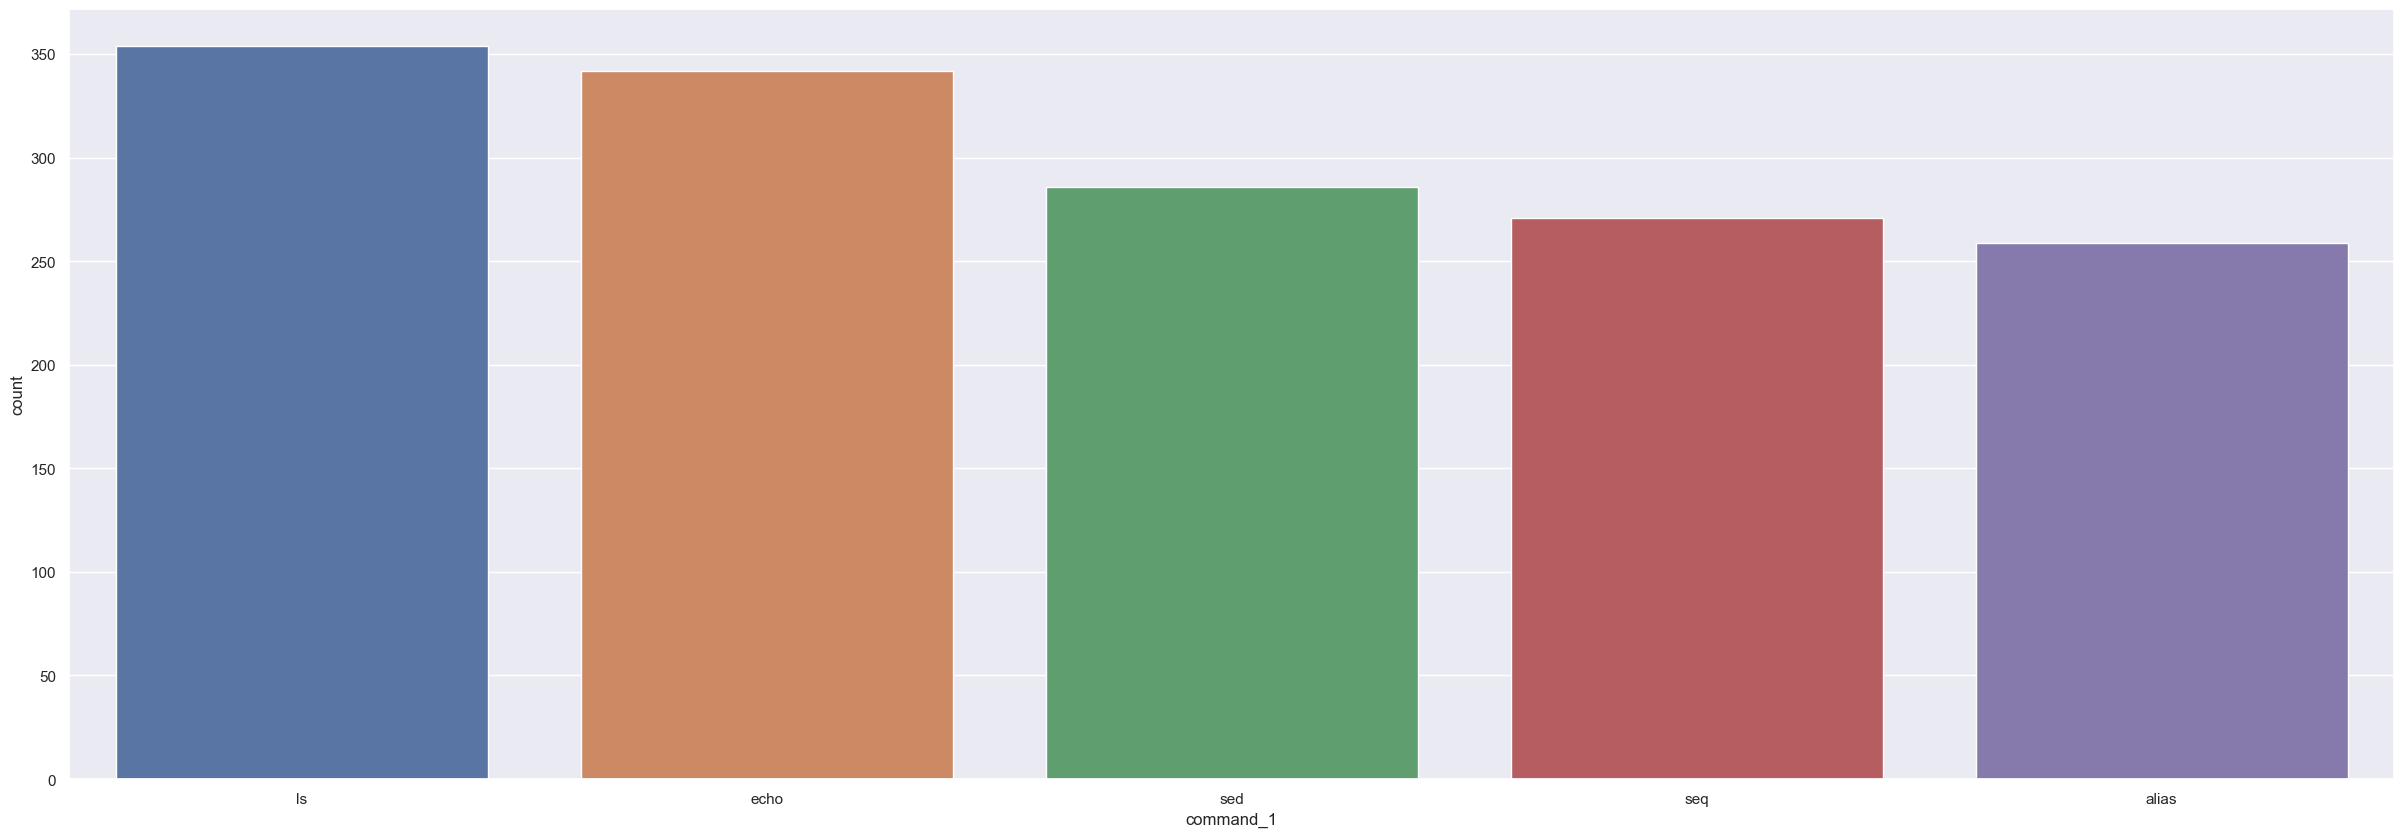

In [11]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(30,10)})

sns.countplot(x=df_distribution["command_1"], order=pd.value_counts(df_distribution["command_1"]).iloc[:5].index)

##### **Data Split**
*   Train: 10085 entries
*   Test: 1261 entries
*   Validation: 1261 entries

In [12]:
x_train, x_test, y_train, y_test = train_test_split(input, output, train_size=0.8, test_size=0.2, shuffle=True, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size=0.5, test_size=0.5, shuffle=True, random_state=0)

train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)
valid = pd.concat([x_val, y_val], axis=1)

In [13]:
train_dataset = Dataset.from_pandas(train)
train_dataset = train_dataset.remove_columns(["__index_level_0__"])

test_dataset = Dataset.from_pandas(test)
test_dataset = test_dataset.remove_columns(["__index_level_0__"])

valid_dataset = Dataset.from_pandas(valid)
valid_dataset = valid_dataset.remove_columns(["__index_level_0__"])

raw_datasets = DatasetDict({"train":train_dataset, "test":test_dataset, "valid":valid_dataset})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 8966
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 1121
    })
    valid: Dataset({
        features: ['input', 'output'],
        num_rows: 1121
    })
})

In [14]:
raw_datasets['train'][400]

{'input': 'Counts the total number of lines in all the files in a git repository.',
 'output': 'git ls-files | xargs cat | wc -l'}

In [15]:
raw_datasets['test'][30]

{'input': 'Print newline separated list of numbers from $start to $end',
 'output': "seq -s'\\n' $start $end"}

#### Fine-tuning: Load Model Checkpoint, Tokenizer, Metrics, Pretrained Weights

In [16]:
# model_checkpoint = 't5-small'
model_checkpoint = 't5-large'
# model_checkpoint = 'google/t5-v1_1-base'
# model_checkpoint = 'google/byt5-small'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

c:\Users\sha\anaconda3\envs\ml\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [17]:
max_input_length = 128
max_target_length = 128

def preprocess_function(examples):
    inputs = [ex for ex in examples['input']]
    targets = [ex for ex in examples['output']]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [18]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Parameter 'function'=<function preprocess_function at 0x000002A36E1DACB0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/9 [00:00<?, ?ba/s]

c:\Users\sha\anaconda3\envs\ml\lib\site-packages\transformers\tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [19]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [20]:
# !pip3 install sacrebleu
# metric = load_metric("sacrebleu")

!pip3 install evaluate
import evaluate
metric = evaluate.load("Josh98/nl2bash_m")

In [21]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [22]:
import torch

torch.cuda.is_available()

True

In [23]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-English-to-BASH",
    evaluation_strategy = "epoch",
    learning_rate=4e-05,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=True,
)

In [24]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [25]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#### Initialize and Begin Training

In [26]:
import numpy as np
from datasets import load_dataset, load_metric, list_metrics
import evaluate

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    exact_match = load_metric("exact_match")
    blue = load_metric("sacrebleu")
    nl2bash_m = evaluate.load("Josh98/nl2bash_m")

    exact_match_result = exact_match.compute(predictions=decoded_preds, references=decoded_labels)
    blue_result = blue.compute(predictions=decoded_preds, references=decoded_labels)
    nl2bash_m_result = nl2bash_m.compute(predictions=decoded_preds, references=decoded_labels)

    # print(exact_match_result["exact_match"])
    # print(blue_result["score"])
    # print(nl2bash_m_result["nl2bash_m"])
    result = {
        "exact_match": exact_match_result["exact_match"],
        "blue": blue_result["score"],
        "nl2bash_m": nl2bash_m_result["nl2bash_m"],
    }
    print("result: ", result)

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    # result["gen_len"] = np.mean(prediction_lens)
    # result = {k: round(v, 4) for k, v in result.items()}
    return result

In [27]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

c:\Users\sha\Downloads\drive-download-20230225T092315Z-001\t5-large-finetuned-English-to-BASH is already a clone of https://huggingface.co/alexsha/t5-large-finetuned-English-to-BASH. Make sure you pull the latest changes with `repo.git_pull()`.


In [28]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: output, input. If output, input are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
c:\Users\sha\anaconda3\envs\ml\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8966
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2805
  Number of trainable parameters = 737668096
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the 

  0%|          | 0/2805 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Saving model checkpoint to t5-large-finetuned-English-to-BASH\checkpoint-500
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-500\config.json
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-500\generation_config.json


{'loss': 1.8852, 'learning_rate': 3.28698752228164e-05, 'epoch': 0.89}


Model weights saved in t5-large-finetuned-English-to-BASH\checkpoint-500\pytorch_model.bin
tokenizer config file saved in t5-large-finetuned-English-to-BASH\checkpoint-500\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\checkpoint-500\special_tokens_map.json
tokenizer config file saved in t5-large-finetuned-English-to-BASH\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: output, input. If output, input are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1121
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/71 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

result:  {'exact_match': 0.0, 'blue': 23.726270434893753, 'nl2bash_m': 0.15521855486173058}
{'eval_loss': 1.1505413055419922, 'eval_exact_match': 0.0, 'eval_blue': 23.726270434893753, 'eval_nl2bash_m': 0.15521855486173058, 'eval_runtime': 44.7735, 'eval_samples_per_second': 25.037, 'eval_steps_per_second': 1.586, 'epoch': 1.0}


Saving model checkpoint to t5-large-finetuned-English-to-BASH\checkpoint-1000
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-1000\config.json
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-1000\generation_config.json


{'loss': 1.1996, 'learning_rate': 2.5739750445632802e-05, 'epoch': 1.78}


Model weights saved in t5-large-finetuned-English-to-BASH\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in t5-large-finetuned-English-to-BASH\checkpoint-1000\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\checkpoint-1000\special_tokens_map.json
tokenizer config file saved in t5-large-finetuned-English-to-BASH\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: output, input. If output, input are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1121
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/71 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

result:  {'exact_match': 0.0, 'blue': 27.680538262863042, 'nl2bash_m': 0.20071364852809992}
{'eval_loss': 0.9344488978385925, 'eval_exact_match': 0.0, 'eval_blue': 27.680538262863042, 'eval_nl2bash_m': 0.20071364852809992, 'eval_runtime': 44.0798, 'eval_samples_per_second': 25.431, 'eval_steps_per_second': 1.611, 'epoch': 2.0}


Saving model checkpoint to t5-large-finetuned-English-to-BASH\checkpoint-1500
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-1500\config.json
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-1500\generation_config.json


{'loss': 0.9911, 'learning_rate': 1.86096256684492e-05, 'epoch': 2.67}


Model weights saved in t5-large-finetuned-English-to-BASH\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in t5-large-finetuned-English-to-BASH\checkpoint-1500\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\checkpoint-1500\special_tokens_map.json
tokenizer config file saved in t5-large-finetuned-English-to-BASH\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: output, input. If output, input are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1121
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/71 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

result:  {'exact_match': 0.0, 'blue': 29.807885927270966, 'nl2bash_m': 0.23461195361284568}
{'eval_loss': 0.8443527817726135, 'eval_exact_match': 0.0, 'eval_blue': 29.807885927270966, 'eval_nl2bash_m': 0.23461195361284568, 'eval_runtime': 45.6994, 'eval_samples_per_second': 24.53, 'eval_steps_per_second': 1.554, 'epoch': 3.0}


Saving model checkpoint to t5-large-finetuned-English-to-BASH\checkpoint-2000
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-2000\config.json
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-2000\generation_config.json


{'loss': 0.8996, 'learning_rate': 1.1479500891265598e-05, 'epoch': 3.57}


Model weights saved in t5-large-finetuned-English-to-BASH\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in t5-large-finetuned-English-to-BASH\checkpoint-2000\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\checkpoint-2000\special_tokens_map.json
tokenizer config file saved in t5-large-finetuned-English-to-BASH\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\special_tokens_map.json
Deleting older checkpoint [t5-large-finetuned-English-to-BASH\checkpoint-500] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: output, input. If output, input are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1121
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_tok

  0%|          | 0/71 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

result:  {'exact_match': 0.0, 'blue': 31.423001668879685, 'nl2bash_m': 0.256021409455843}
{'eval_loss': 0.8015314340591431, 'eval_exact_match': 0.0, 'eval_blue': 31.423001668879685, 'eval_nl2bash_m': 0.256021409455843, 'eval_runtime': 43.6938, 'eval_samples_per_second': 25.656, 'eval_steps_per_second': 1.625, 'epoch': 4.0}


Saving model checkpoint to t5-large-finetuned-English-to-BASH\checkpoint-2500
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-2500\config.json
Configuration saved in t5-large-finetuned-English-to-BASH\checkpoint-2500\generation_config.json


{'loss': 0.8403, 'learning_rate': 4.349376114081997e-06, 'epoch': 4.46}


Model weights saved in t5-large-finetuned-English-to-BASH\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in t5-large-finetuned-English-to-BASH\checkpoint-2500\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\checkpoint-2500\special_tokens_map.json
tokenizer config file saved in t5-large-finetuned-English-to-BASH\tokenizer_config.json
Special tokens file saved in t5-large-finetuned-English-to-BASH\special_tokens_map.json
Deleting older checkpoint [t5-large-finetuned-English-to-BASH\checkpoint-1000] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: output, input. If output, input are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1121
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_to

  0%|          | 0/71 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

result:  {'exact_match': 0.0, 'blue': 31.61549609829295, 'nl2bash_m': 0.2604817127564674}
{'eval_loss': 0.788204550743103, 'eval_exact_match': 0.0, 'eval_blue': 31.61549609829295, 'eval_nl2bash_m': 0.2604817127564674, 'eval_runtime': 43.0264, 'eval_samples_per_second': 26.054, 'eval_steps_per_second': 1.65, 'epoch': 5.0}
{'train_runtime': 2088.6863, 'train_samples_per_second': 21.463, 'train_steps_per_second': 1.343, 'train_loss': 1.1247267126399565, 'epoch': 5.0}


TrainOutput(global_step=2805, training_loss=1.1247267126399565, metrics={'train_runtime': 2088.6863, 'train_samples_per_second': 21.463, 'train_steps_per_second': 1.343, 'train_loss': 1.1247267126399565, 'epoch': 5.0})

In [29]:
# trainer.push_to_hub()